## Titanic Train

### Description

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

Titanic dataset contains information about the people involved in the Titanic shipwreck

Goal: 

Predict if a passenger survived the sinking of the Titanic or not.

#### let's start with importing libraries

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import math as mt
#import missingno as m
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, f1_score,roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# load dataset
dataset=pd.read_csv('titanictrain.csv')

In [3]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3.000,"Braund, Mr. Owen Harris",male,22.000,1.000,0.000,A/5 21171,7.250,NaN,S
1,2,1,1.000,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1.000,0.000,PC 17599,71.283,C85,C
2,3,1,3.000,"Heikkinen, Miss. Laina",female,26.000,0.000,0.000,STON/O2. 3101282,7.925,NaN,S
3,4,1,1.000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1.000,0.000,113803,53.100,C123,S
4,5,0,3.000,"Allen, Mr. William Henry",male,35.000,0.000,0.000,373450,8.050,NaN,S


from above info, we can say that there is null value available in the dataset

### Exploaratory Data Analysis

Let's begin some exploratory data analysis! 

#### Missing data

<AxesSubplot:>

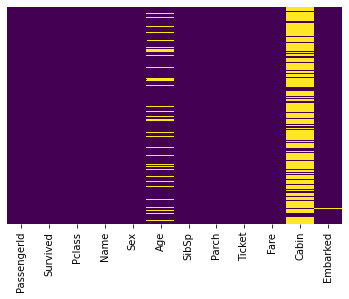

In [4]:
sns.heatmap(dataset.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [5]:
dataset.isnull().sum().sort_values(ascending=False)

Cabin          688
Age            178
Embarked         3
Fare             1
Ticket           1
Parch            1
SibSp            1
Sex              1
Name             1
Pclass           1
Survived         0
PassengerId      0
dtype: int64

Roughly 20 percent of the age data is missing. The proportion of age is likely small enough for resonable replacement with some form of imputation. Looking at the cabin column, it looks likewe are just missing too much of that data to do something useful wiht a basic level. We'll probably drop this later or change it to another feature like "Cabin known: 1 or 0". 

#### Let's continue on by visualizing some more of the data!

<AxesSubplot:xlabel='Survived', ylabel='count'>

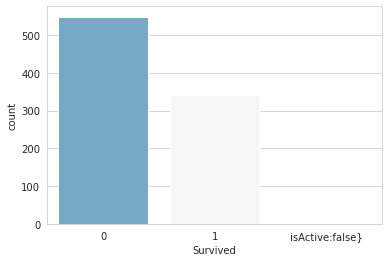

In [6]:
sns.set_style('whitegrid')
sns.countplot(x="Survived",data=dataset,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

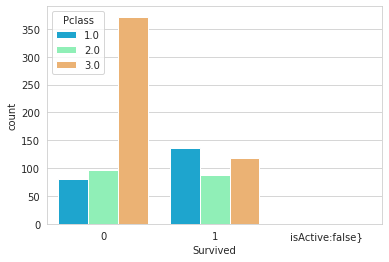

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=dataset, palette='rainbow')

<AxesSubplot:>

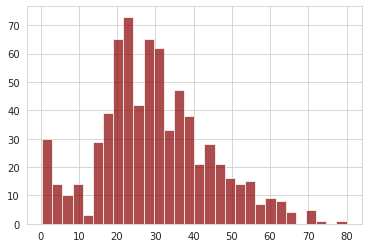

In [8]:
dataset['Age'].hist(bins=30,color='darkred',alpha=0.7)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

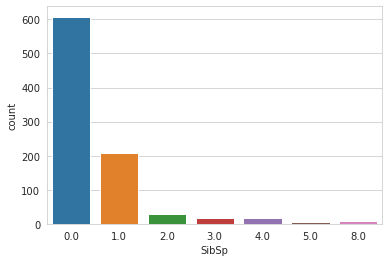

In [9]:
sns.countplot(x='SibSp',data=dataset)

<AxesSubplot:>

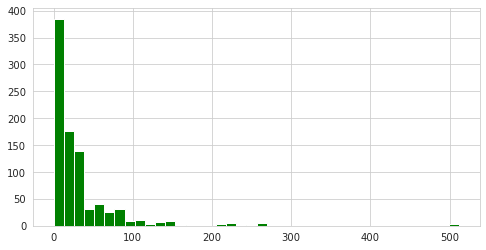

In [10]:
dataset['Fare'].hist(color='green',bins=40,figsize=(8,4))

### Data cleaning

We want ot fill in missing age data instead of just dropping the missing age data rows. One way to do this by filling in the mean age of all the passengers(imputation). However we can be smarter about this and check the average age by passenger class.

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

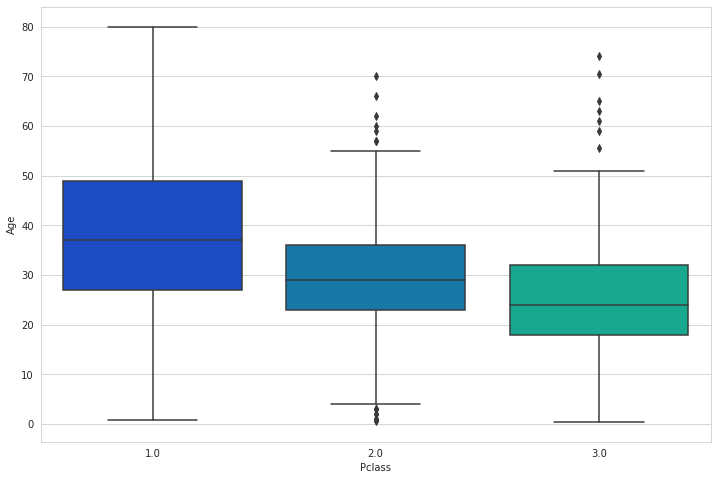

In [11]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Pclass',y='Age',data=dataset, palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [12]:
def impute_age(cols):
    Age=cols[0]
    Pclass=cols[1]
    
    if pd.isnull(Age):
        if Pclass ==1:
            return 37
        elif Pclass==2:
            return 29
        else:
            return 24
        
    else:
        return Age

Now apply that function

In [13]:
dataset['Age']=dataset[['Age','Pclass']].apply(impute_age,axis=1)

In [14]:
dataset['Embarked']=dataset['Embarked'].fillna('S')

now let's check that heatmap again

<AxesSubplot:>

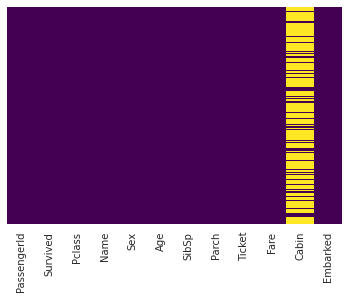

In [15]:
sns.heatmap(dataset.isnull(),yticklabels=False,cbar=False,cmap='viridis')

now, let's go ahead and drop the cabin column and the row in Embarked that is NaN

We will sum of family member

In [16]:
dataset.drop('Cabin',axis=1,inplace=True)

In [17]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3.000,"Braund, Mr. Owen Harris",male,22.000,1.000,0.000,A/5 21171,7.250,S
1,2,1,1.000,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1.000,0.000,PC 17599,71.283,C
2,3,1,3.000,"Heikkinen, Miss. Laina",female,26.000,0.000,0.000,STON/O2. 3101282,7.925,S
3,4,1,1.000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1.000,0.000,113803,53.100,S
4,5,0,3.000,"Allen, Mr. William Henry",male,35.000,0.000,0.000,373450,8.050,S


In [18]:
dataset.dropna(inplace=True)

#### Converting Categorical features

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs

In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    object 
 1   Survived     891 non-null    object 
 2   Pclass       891 non-null    float64
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    float64
 7   Parch        891 non-null    float64
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(5), object(6)
memory usage: 83.5+ KB


In [20]:
sex=pd.get_dummies(dataset['Sex'],drop_first=True)
embark=pd.get_dummies(dataset['Embarked'],drop_first=True)

In [21]:
dataset.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [22]:
dataset=pd.concat([dataset,sex,embark],axis=1)

In [23]:
dataset.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3.000,22.000,1.000,0.000,7.250,1,0,1
1,2,1,1.000,38.000,1.000,0.000,71.283,0,0,0
2,3,1,3.000,26.000,0.000,0.000,7.925,0,0,1
3,4,1,1.000,35.000,1.000,0.000,53.100,0,0,1
4,5,0,3.000,35.000,0.000,0.000,8.050,1,0,1


### Now, our data is ready for our model!

## Logistic Regression model

let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training.)

In [24]:
X_train,X_test,y_train,y_test=train_test_split(dataset.drop(['Survived'],axis=1),dataset['Survived'],test_size=0.10,random_state=101)

### Training and predicting

In [25]:
lm=LogisticRegression()
lm.fit(X_train,y_train)

LogisticRegression()

In [26]:
prediction=lm.predict(X_test)
X_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
331,332,1.000,45.500,0.000,0.000,28.500,1,0,1
700,701,1.000,18.000,1.000,0.000,227.525,0,0,0
748,749,1.000,19.000,1.000,0.000,53.100,1,0,1
751,752,3.000,6.000,0.000,1.000,12.475,1,0,1
481,482,2.000,29.000,0.000,0.000,0.000,1,0,1


In [27]:
prediction

array(['0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1',
       '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0',
       '0', '0', '0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0',
       '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '1', '1', '1', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0',
       '0', '1', '1', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0',
       '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1'],
      dtype=object)

### Evalution

we can check precision, recall, f1-score using classification report!

In [28]:
print(confusion_matrix(y_test,prediction))

[[46  5]
 [16 23]]


In [29]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81        51
           1       0.82      0.59      0.69        39

    accuracy                           0.77        90
   macro avg       0.78      0.75      0.75        90
weighted avg       0.78      0.77      0.76        90



### Decision Tree Classification

In [30]:
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [31]:
dtPred=dt.predict(X_test)

In [32]:
print(dtPred)

['0' '1' '0' '1' '0' '0' '0' '0' '1' '1' '0' '1' '1' '0' '0' '1' '1' '0'
 '0' '0' '0' '0' '1' '0' '0' '0' '0' '1' '0' '0' '1' '1' '0' '0' '0' '1'
 '0' '0' '0' '1' '1' '1' '0' '0' '0' '0' '1' '1' '0' '0' '0' '0' '1' '1'
 '1' '0' '0' '0' '0' '1' '1' '0' '0' '0' '0' '0' '1' '0' '1' '0' '0' '0'
 '0' '0' '0' '1' '0' '0' '0' '1' '0' '1' '0' '0' '1' '0' '0' '1' '0' '1']


In [33]:
print(confusion_matrix(y_test,dtPred))

[[44  7]
 [15 24]]


In [34]:
print(classification_report(y_test,dtPred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80        51
           1       0.77      0.62      0.69        39

    accuracy                           0.76        90
   macro avg       0.76      0.74      0.74        90
weighted avg       0.76      0.76      0.75        90



### Random Forest Classification

In [35]:
rf= RandomForestClassifier(n_estimators=500)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=500)

In [36]:
rfpred=rf.predict(X_test)

In [37]:
print(confusion_matrix(y_test,rfpred))

[[48  3]
 [15 24]]


In [38]:
print(classification_report(y_test,rfpred))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84        51
           1       0.89      0.62      0.73        39

    accuracy                           0.80        90
   macro avg       0.83      0.78      0.78        90
weighted avg       0.82      0.80      0.79        90



### Model Saving

In [40]:
import joblib
joblib.dump(rf,"titanictrain.pkl")

['titanictrain.pkl']

### loding the saved model

In [41]:
model=joblib.load('titanictrain.pkl')

In [42]:
prediction=model.predict(X_test)

In [43]:
prediction=pd.DataFrame(prediction)

In [44]:
prediction.to_csv('Results.csv',index=False)